# Fashion MNIST Stacking + Unstacking

## Downloading the Data

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [8]:
data_folder = '../data/'
dataset_name = 'Fashion_MNIST'
dataset_folder = os.path.join(data_folder, dataset_name)

In [10]:
if os.path.exists(dataset_folder):
    print(f"Using existing dataset folder: {dataset_folder}")
    fashion_mnist_data = torchvision.datasets.FashionMNIST(data_folder, 
                                            train=True,
                                            transform=torchvision.transforms.ToTensor())
    # NOTE:
    # transform=torchvision.transforms.ToTensor(): Converts the PIL Image or NumPy array to a 
    # torch.FloatTensor and scales the pixel values to the range [0.0, 1.0].
else:
    print(f"Dataset folder '{dataset_folder}' does not exist. Downloading dataset...")
    fashion_mnist_data = torchvision.datasets.FashionMNIST(data_folder, 
                                            train=True,
                                            transform=torchvision.transforms.ToTensor(), 
                                            download=True)

Dataset folder '../data/Fashion_MNIST' does not exist. Downloading dataset...


### Checking the First 3 Images

First image shape: torch.Size([1, 28, 28])
First image label: 9


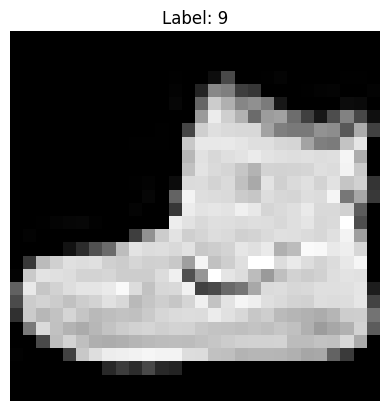

In [14]:
# Getting the first image in the dataset
first_image, first_label = fashion_mnist_data[0]
print("First image shape:", first_image.shape)
print("First image label:", first_label)
plt.imshow(first_image.squeeze(), cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()

Second image shape: torch.Size([1, 28, 28])
Second image label: 0


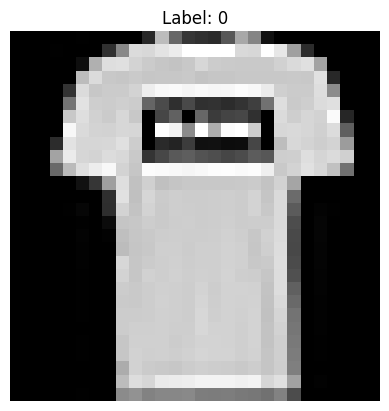

In [21]:
# Getting the second image in the dataset
second_image, second_label = fashion_mnist_data[1]
print("Second image shape:", second_image.shape)
print("Second image label:", second_label)
plt.imshow(second_image.squeeze(), cmap='gray')
plt.title(f"Label: {second_label}")
plt.axis('off')
plt.show()

Third image shape: torch.Size([1, 28, 28])
Third image label: 0


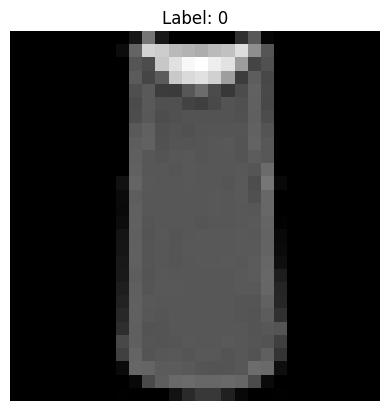

In [32]:
# Getting the third image in the dataset
third_image, third_label = fashion_mnist_data[2]
print("Third image shape:", third_image.shape)
print("Third image label:", third_label)
plt.imshow(third_image.squeeze(), cmap='gray')
plt.title(f"Label: {third_label}")
plt.axis('off')
plt.show()

## Stacking

### Stacking the First 3 Images

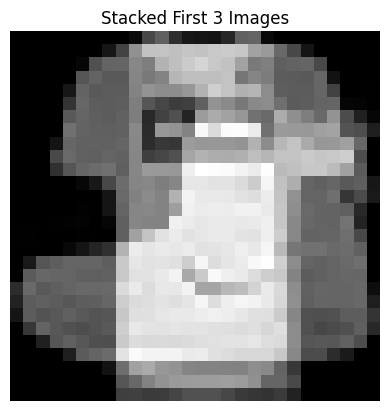

Stacked First 3 images shape: torch.Size([1, 28, 28])


In [36]:
images = []

for i in range(3):
    image, label = fashion_mnist_data[i]
    images.append(image)

stacked = torch.stack(images)
overlay_all = stacked.mean(dim=0)

plt.imshow(overlay_all.squeeze(), cmap='gray')
plt.title("Stacked First 3 Images")
plt.axis('off')
plt.show()

print("Stacked First 3 images shape:", overlay_all.shape)

## CNN Classes and Functions

In [56]:
transform = transforms.ToTensor()
fashion_mnist_train = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)

100.0%


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100.0%


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100.0%


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100.0%

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [126]:
class OverlayDataset(Dataset):
    """
    Returns:
        overlay: overlayed image (1, 28, 28)
        imgA: first original image (1, 28, 28)
        imgB: second original image (1, 28, 28)
    """
    def __init__(self, base_dataset, num_pairs=None):
        self.base = base_dataset
        self.num_pairs = num_pairs if num_pairs else len(base_dataset) - 1

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, idx):
        imgA, _ = self.base[idx]
        imgB, _ = self.base[idx + 1]
        overlay = (imgA + imgB) / 2.0
        return overlay, imgA, imgB

In [116]:
overlay_dataset = OverlayDataset(fashion_mnist_train)
dataloader = DataLoader(overlay_dataset, batch_size=32, shuffle=True)

In [117]:
class SimpleSeparatorCNN(nn.Module):
    """
    Simple CNN that takes overlay image and outputs two separated images.
    """
    def __init__(self):
        super().__init__()

        # Shared convolution layers
        self.shared = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU()
        )

        # Branch for first image
        self.branchA = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

        # Branch for second image
        self.branchB = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.shared(x)
        outA = self.branchA(features)
        outB = self.branchB(features)
        return outA, outB

In [118]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model = SimpleSeparatorCNN().to(device)

In [119]:
def separation_loss(predA, predB, imgA, imgB):
    """
    Handles the case where the network might swap outputs.
    """
    loss1 = F.mse_loss(predA, imgA) + F.mse_loss(predB, imgB)
    loss2 = F.mse_loss(predA, imgB) + F.mse_loss(predB, imgA)
    return torch.min(loss1, loss2)

In [120]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [121]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for overlay, imgA, imgB in dataloader:
        overlay = overlay.to(device)
        imgA = imgA.to(device)
        imgB = imgB.to(device)

        optimizer.zero_grad()
        predA, predB = model(overlay)

        loss = separation_loss(predA, predB, imgA, imgB)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

Epoch 1/10, Loss: 0.0898
Epoch 2/10, Loss: 0.0864
Epoch 3/10, Loss: 0.0862
Epoch 4/10, Loss: 0.0860
Epoch 5/10, Loss: 0.0860


KeyboardInterrupt: 

In [113]:
def show_overlay_results(model, dataset, index=0):
    """
    Display:
    - Overlay input
    - Original images A and B
    - Predicted images A and B
    """
    model.eval()
    
    # Get overlay and original images
    overlay, imgA, imgB = dataset[index]
    
    # Add batch dimension and move to device
    overlay_batch = overlay.unsqueeze(0).to(next(model.parameters()).device)
    
    with torch.no_grad():
        predA, predB = model(overlay_batch)
        predA = predA.squeeze().cpu()
        predB = predB.squeeze().cpu()
    
    # Plot
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,5,1)
    plt.imshow(overlay.squeeze(), cmap='gray')
    plt.title("Overlay")
    plt.axis('off')
    
    plt.subplot(1,5,2)
    plt.imshow(imgA.squeeze(), cmap='gray')
    plt.title("Original A")
    plt.axis('off')
    
    plt.subplot(1,5,3)
    plt.imshow(imgB.squeeze(), cmap='gray')
    plt.title("Original B")
    plt.axis('off')
    
    plt.subplot(1,5,4)
    plt.imshow(predA, cmap='gray')
    plt.title("Predicted A")
    plt.axis('off')
    
    plt.subplot(1,5,5)
    plt.imshow(predB, cmap='gray')
    plt.title("Predicted B")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

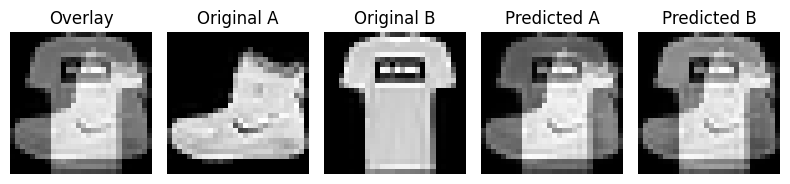

In [114]:
show_overlay_results(model, overlay_dataset, index=0)

In [115]:
print(predA.shape)  # should be (28,28)
print(predB.shape)  # should be (28,28)

# Compare with original
overlay_diffA = torch.abs(predA - imgA)
overlay_diffB = torch.abs(predB - imgB)
print("Mean error A:", overlay_diffA.mean().item())
print("Mean error B:", overlay_diffB.mean().item())

torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
Mean error A: 0.14806118607521057
Mean error B: 0.1448245346546173


#### Testing

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualSeparatorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initial conv
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual block 1
        self.res1_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.res1_bn1 = nn.BatchNorm2d(128)
        self.res1_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.res1_bn2 = nn.BatchNorm2d(64)
        
        # Residual block 2
        self.res2_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.res2_bn1 = nn.BatchNorm2d(128)
        self.res2_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.res2_bn2 = nn.BatchNorm2d(64)
        
        # Branch for first image
        self.branchA = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        # Branch for second image
        self.branchB = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Initial conv
        out = F.relu(self.bn1(self.conv1(x)))
        
        # Residual block 1
        res = F.relu(self.res1_bn1(self.res1_conv1(out)))
        res = self.res1_bn2(self.res1_conv2(res))
        out = F.relu(out + res)  # residual connection
        
        # Residual block 2
        res = F.relu(self.res2_bn1(self.res2_conv1(out)))
        res = self.res2_bn2(self.res2_conv2(res))
        out = F.relu(out + res)  # residual connection
        
        # Branch outputs
        outA = self.branchA(out)
        outB = self.branchB(out)
        
        return outA, outB


In [138]:
overlay_dataset = OverlayDataset(fashion_mnist_train, num_pairs=10000)
dataloader = DataLoader(overlay_dataset, batch_size=32, shuffle=True)

In [139]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model = ResidualSeparatorCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [143]:
def separation_loss_l1(predA, predB, imgA, imgB):
    loss1 = F.l1_loss(predA, imgA) + F.l1_loss(predB, imgB)
    loss2 = F.l1_loss(predA, imgB) + F.l1_loss(predB, imgA)
    return torch.min(loss1, loss2)

In [144]:
num_epochs = 15  # increase if needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for overlay, imgA, imgB in dataloader:
        overlay = overlay.to(device)
        imgA = imgA.to(device)
        imgB = imgB.to(device)

        # -------------------------
        # Randomized overlay weighting
        # -------------------------
        # Generate random weights per image in batch
        w = torch.rand(overlay.size(0), 1, 1, 1, device=device) * 0.2 + 0.4  # between 0.4 and 0.6
        overlay_rand = w * imgA + (1 - w) * imgB

        # -------------------------
        optimizer.zero_grad()
        predA, predB = model(overlay_rand)
        loss = separation_loss_l1(predA, predB, imgA, imgB)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

/Users/jordanstanley/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/15, Loss: 0.2745
Epoch 2/15, Loss: 0.2694
Epoch 3/15, Loss: 0.2665
Epoch 4/15, Loss: 0.2645
Epoch 5/15, Loss: 0.2651
Epoch 6/15, Loss: 0.2622
Epoch 7/15, Loss: 0.2634
Epoch 8/15, Loss: 0.2621
Epoch 9/15, Loss: 0.2617
Epoch 10/15, Loss: 0.2619
Epoch 11/15, Loss: 0.2593
Epoch 12/15, Loss: 0.2622
Epoch 13/15, Loss: 0.2629
Epoch 14/15, Loss: 0.2595
Epoch 15/15, Loss: 0.2596


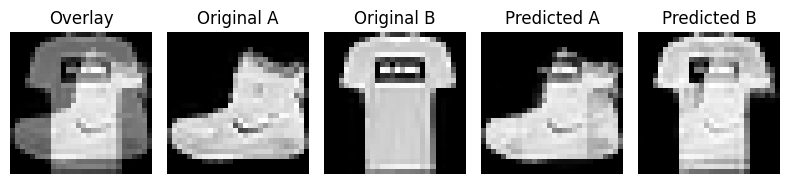

In [145]:
show_overlay_results(model, overlay_dataset, index=0)